```
Domande:
    - Ci sono multiple etichette contrastanti tra quelle nel file in radice di Recordings_OM e quelle nelle singole cartelle
    - Missing full video t_052 07/08 (id 27 - 28) trying reconstruct segmentation from visual inspection
```

# Body Markers Reduced

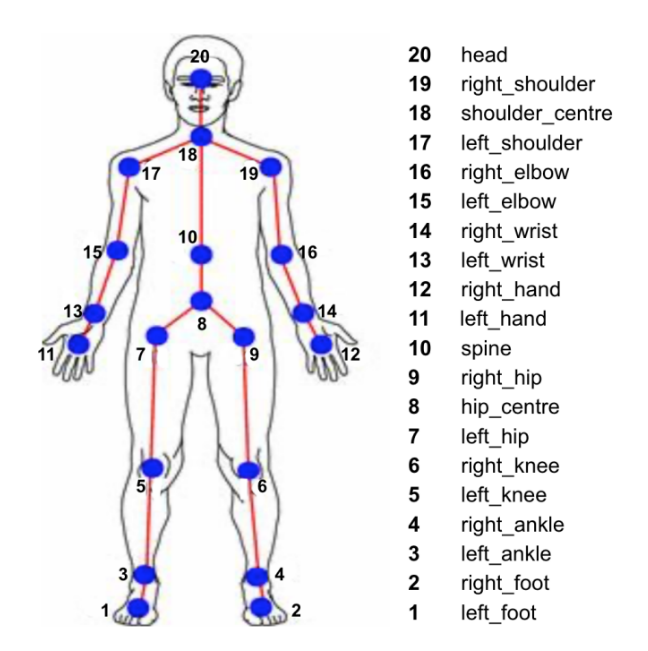

# Infos about the dataset

```
Video Names Mapping and manual annotation:

Muriel t_003.1 ==> 1 ==> Shoc/Rsho
Muriel t_003.2 ==> 2 ==> Hipc/Head !!
Muriel t_003.3 ==> 3 ==> Rhip/Hipc
Muriel t_004 ==> 4 ==> Shoc/Lsho

Marianne t_002.1 ==> 5 ==> Shoc/Head
Marianne t_002.2 ==> 6 ==> Rknee/Rank
Marianne t_003 ==> 7 ==> Lsho/Shoc
Marianne t_005.1 ==> 8 ==> Rsho/Shoc
Marianne t_005.2 ==> 9 ==> Rank/Hipc !!
Marianne t_012 ==> 10 ==> Shoc/Lsho !!

Cora t_028.1 ==> 11 ==> Rwrist/Rhand
Cora t_028.2 ==> 12 ==> Relb/Head
Cora t_028.3 ==> 13 ==> Lank/Lhip
Cora t_028.4 ==> 14 ==> Lknee/Lhip
Cora t_028.5 ==> 15 ==> Lwrist/Lsho
Cora t_028.6 ==> 16 ==> Hipc/Shoc !!

No OoM.1 (07-07 t_052) ==> 19 ==> No
No OoM.2 (07-07 t_052) ==> 18 ==> No

07-07 t_051 ==> 17 ==> Rknee/Lknee !!
07-07 t_052 ==> 20 ==> Shoc/Hipc !!
07-07 t_060 ==> 21 ==> Rsho/Relb
07-07 t_061 ==> 22 ==> Lelb/Shoc
07-07 t_063 ==> 23 ==> Lelb/Shoc
07-07 t_064 ==> 24 ==> Relb/Rwrist

07-08 t_052_A.1 ==> 25 ==> Lknee/Rknee !!
07-08 t_052_B.1 ==> 26 ==> Lknee/Shoc
07-08 t_052_A.2 ==> 27 ==> Shoc/Lelb
07-08 t_052_B.2 ==> 28 ==> Rknee/Lknee !!
07-08 t_053_A.1 ==> 29 ==> Lknee/Rknee
07-08 t_053_B.1 ==> 30 ==> Rknee/Shoc
07-08 t_053_A.2 ==> 31 ==> Rhip/Shoc
07-08 t_053_B.2 ==> 32 ==> Rknee/Relb

07-13 t_061_A.1 ==> 33 ==> Lelb/Relb
07-13 t_061_B.1 ==> 34 ==> Lknee/Rknee
07-13 t_061_A.2 ==> 35 ==> Rknee/Shoc
07-13 t_061_B.2 ==> 36 ==> Rsho/Relb

```

Id to time slices
```
1 ==> 0:37 - 0:40
2 ==> 0:58 - 1:04
3 ==> 1:13 - 1:16
4 ==> 0:13 - 0:16
5 ==> 00:36.3 - 00:41.5
6 ==> 00:44.4 - 00:50.0
7 ==> 00:03.0 - 00:08.9
8 ==> 00:04 - 00:09
9 ==> 00:09.2 - 00:13.4
10 ==> 00:14 - 00:20.1
11 ==> 00:04.7 - 00:08.3
12 ==> 00:12.8 - 00:18.5
13 ==> 00:24.2 - 00:29.7
14 ==> 00:29.8 - 00:36.2
15 ==> 00:51.1 - 00:55.0
16 ==> 00:57.9 - 01:03.8
17 ==> 00:16.9 - 00:18.7
18 ==> 00:15 - 00:18
19 ==> 00:11.5 - 00:13.2
20 ==> 00:19 - 00:21.5
21 ==> 00:02 - 00:05
22 ==> 00:58 - 01:01
23 ==> 00:25.5 - 00:28.5
24 ==> 00:02.5 - 00:05.5
25 ==> 00:08.1 - 00:11.8
26 ==> 00:08.1 - 00:11.8
27 ==> 00:11.8 - 00:15.8
28 ==> 00:11.8 - 00:15.8
29 ==> 00:22 - 00:24.5
30 ==> 00:22 - 00:24.5
31 ==> 00:25 - 00:27.2
32 ==> 00:25 - 00:27.2
33 ==> 00:29 - 00:32.1
34 ==> 00:29 - 00:32.1
35 ==> 01:14 - 01:20
36 ==> 01:14 - 01:20
```

In [25]:
import pandas as pd

DATA_POSITION_PATH = "data/position/"
DATA_DERIVATED_PATH = "data/derivated/"
MURIEL_POS = DATA_POSITION_PATH+"muriel/"
MARIANNE_POS = DATA_POSITION_PATH+"marianne/"
CORA_POS = DATA_POSITION_PATH+"cora/"
JUL_SEV_POS = DATA_POSITION_PATH+"07-07/"
JUL_EI_POS = DATA_POSITION_PATH+"07-08/"
JUL_THI_POS = DATA_POSITION_PATH+"07-13/"

# mappings are index -> (file_path, start_end_segment_tuple) in seconds
# TODO movements directions must be set consistently but in trials 1 -> 24 are in a way, while 25 to 36 are flipped 
drive_pos_map = {   1:  (MURIEL_POS+"t_003_finalclean.tsv",(37,40)),
                    2:  (MURIEL_POS+"t_003_finalclean.tsv",(58,64)),
                    3:  (MURIEL_POS+"t_003_finalclean.tsv",(73,76)),
                    4:  (MURIEL_POS+"t_004_finalclean.tsv",(13,16)),
                    5:  (MARIANNE_POS+"t_002_finalclean.tsv",(36.3,41.5)),
                    6:  (MARIANNE_POS+"t_002_finalclean.tsv",(44.4,50)),
                    7:  (MARIANNE_POS+"t_003_finalclean.tsv",(3,8.9)),
                    8:  (MARIANNE_POS+"t_005_finalclean.tsv",(4,9)),
                    9:  (MARIANNE_POS+"t_005_finalclean.tsv",(9.2,13.4)),
                    10: (MARIANNE_POS+"t_012_finalclean.tsv",(14,20.1)),
                    11: (CORA_POS+"t_028_finalclean.tsv",(4.7,8.3)),
                    12: (CORA_POS+"t_028_finalclean.tsv",(12.8,18.5)),
                    13: (CORA_POS+"t_028_finalclean.tsv",(24.2,29.7)),
                    14: (CORA_POS+"t_028_finalclean.tsv",(29.8,36.2)),
                    15: (CORA_POS+"t_028_finalclean.tsv",(51.1,55)),
                    16: (CORA_POS+"t_028_finalclean.tsv",(57.9,63.8)),
                    17: (JUL_SEV_POS+"t_051_finalclean.tsv",(16.9,18.7)),
                    18: (JUL_SEV_POS+"t_052_finalclean.tsv",(11.5,13.2)),
                    19: (JUL_SEV_POS+"t_052_finalclean.tsv",(15,18)),
                    20: (JUL_SEV_POS+"t_052_finalclean.tsv",(19,21.5)),
                    21: (JUL_SEV_POS+"t_060_finalclean.tsv",(2,5)),
                    22: (JUL_SEV_POS+"t_061_finalclean.tsv",(58,61)),
                    23: (JUL_SEV_POS+"t_063_finalclean.tsv",(25.5,28.5)),
                    24: (JUL_SEV_POS+"t_064_finalclean.tsv",(2.5,5.5)),

                    # TODO all these following have a problem with the head position and many with some joints going crazy
                    # A_B trials maybe should be turned in front instead of on a side for consistency
                    25: (JUL_EI_POS+"t_052_A_finalclean.tsv",(8.1,11.8)),       # ball catch left side
                    26: (JUL_EI_POS+"t_052_B_finalclean.tsv",(11.8,15.1)),      # ball catch right side
                    27: (JUL_EI_POS+"t_052_A_finalclean.tsv",(12.15,14.7)),     # ball throw left side
                    28: (JUL_EI_POS+"t_052_B_finalclean.tsv",(8.5,11.8)),       # ball throw right side
                    29: (JUL_EI_POS+"t_053_A_finalclean.tsv",(22,24.5)),        # ball high throw left side
                    30: (JUL_EI_POS+"t_053_B_finalclean.tsv",(22,24.5)),        # ball side catch right side
                    31: (JUL_EI_POS+"t_053_A_finalclean.tsv",(25,27.2)),        # ball throw left side
                    32: (JUL_EI_POS+"t_053_B_finalclean.tsv",(25,27.2)),        # ball catch right side
                    33: (JUL_THI_POS+"t_061_A_finalclean.tsv",(29,32.1)),       # ball throw cheat left side
                    34: (JUL_THI_POS+"t_061_B_finalclean.tsv",(29,32.1)),       # ball catch right side TODO error in joint 
                    35: (JUL_THI_POS+"t_061_A_finalclean.tsv",(74,80)),         # right ball catch left side TODO many joints going crazy
                    36: (JUL_THI_POS+"t_061_B_finalclean.tsv",(74,80))          # ball catch right side
                }

data = drive_pos_map[25]
table = pd.read_table(data[0])
start_end_seconds = data[1]
table = table[table["Time"].between(start_end_seconds[0],start_end_seconds[1])]

In [26]:
from matplotlib import pyplot as plt
%matplotlib
from matplotlib.widgets import Slider
import numpy as np


plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tableNoTime = table.iloc[:,1:]
timeCol = table.iloc[:,0]
tableX = tableNoTime.iloc[:,::3]
tableY = tableNoTime.iloc[:,1::3]
tableZ = tableNoTime.iloc[:,2::3]

minMax = np.zeros((2,3))
minMax[0,:] = [tableX.values.min(),tableY.values.min(),tableZ.values.min()]
minMax[1,:] = [tableX.values.max(),tableY.values.max(),tableZ.values.max()]

print(minMax)

# Set appropriate axis limits
ax.set_xlim([minMax[0,0],minMax[1,0]])
ax.set_ylim([minMax[0,1],minMax[1,1]])
ax.set_zlim([minMax[0,2],minMax[1,2]])

# Set the initial time index
time_index = 0

#plt.title('3D Movement')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Movement')

# Function to update the plot based on the slider value
def update_plot(val):
    ax.cla()  # Clear the previous plot
    
    # Filter the data based on the current time index
    filteredX = tableX.iloc[val]
    filteredY = tableY.iloc[val]
    filteredZ = tableZ.iloc[val]
    
    ax.scatter(filteredX,filteredY,filteredZ)

    ax.set_xlim([minMax[0,0],minMax[1,0]])
    ax.set_ylim([minMax[0,1],minMax[1,1]])
    ax.set_zlim([minMax[0,2],minMax[1,2]])
    
    fig.canvas.draw_idle()

# Create a slider widget
slider_ax = plt.axes([0.2, 0.03, 0.6, 0.03])
slider = Slider(slider_ax, 'TimeIndex', 0, table.shape[0]-1, valinit=time_index, valstep=1)

# Register the update_plot function with the slider widget
slider.on_changed(update_plot)

# Initial plot
update_plot(time_index)

# Show the plot
plt.show()


Using matplotlib backend: TkAgg
[[-1.9557284   0.49115844  0.02575404]
 [-0.86239274  1.31491261  1.28936837]]


# May try LSTM as ML approach

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import LSTM, GRU
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import MinMaxScaler